# Capstone Project: Can We Track Pro-Ukrainian Sentiment Through Tweets?

**Overview:** This project uses Natural Language Processing to classify tweets as Pro-Ukrainian following the Russian invasion of Uktraine, and then compares the performance of Classification models on a tweet dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import re
import sys
import os
import nltk
import string
from textblob import TextBlob

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Chelly
[nltk_data]     Kearney\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Business Understanding

On February 24, 2022, Russia invaded Ukraine. This led to the largest refugee and humanitarian crisis within Europe since the Yugoslav Wars in the 1990s. According to a report by the [Council on Foreign Relations](https://www.cfr.org/article/how-much-aid-has-us-sent-ukraine-here-are-six-charts), forty-seven countries have provided military aid to Ukraine. The U.S. alone has directed more than \\$75 billion in assistance for humanitarian, financial, and military support. Ukraine expects a \\$38 billion budget deficit this year and the Ukrainian government is requesting an additional \$14 billion in foreign aid for rapid reconstruction of critical infrastructure [(Reuters).](https://www.reuters.com/world/europe/ukraine-says-its-received-167-bln-foreign-aid-this-year-2023-05-11/). Continued foreign aid is heavily dependent on public support for Ukraine. 

The goal of this project is to determine if we can track public sentiment for Ukraine through tweets.

## Data Understanding

The dataset used for this project comes from Daria Purtova on [Kaggle.](https://www.kaggle.com/datasets/foklacu/ukraine-war-tweets-dataset-65-days) Purtova compiled tweets between January 1, 2022 to March 6, 2022. She searched on the following phrases and compiled results into 8 separate CSV files based on the search phrases.

* ukraine war
* ukraine troops
* ukraine border
* ukraine NATO
* StandWithUkraine
* russian troops
* russian border ukraine
* russia invade

Each file consisted of 29 features. Some of the columns were identifiers, not unique, redundant or not populated enough to be useful. Nine of the features were useful for this study. They include the following:

* **Date** - the date the tweet was posted (object)
* **Content** - the text of the tweet (object)
* **replyCount** - the number of replies to the tweet (int64)
* **retweetCount** - the number of times the tweet was retweeted (int64)
* **likeCount** - the number of times the tweet was liked (int64)
* **quoteCount** - the number of times the tweet was quoted (int64)
* **SourceLabel** - the type of app from which the tweet was sent (e.g. iPhone, Android, Web app) (object)
* **hashtags** - hashtags included in the text
* **Searh** - the search phrase used to compile the text

The language of the text was one of the features, but only English texts were used for this study. Only texts that included hashtags were used for this study. To save on computational time, 7000 tweets were randomnly selected from each of the 8 CSV files to make the final dataset.

## Data Preparation

To save on computational time - clean each file separately and reduce. Then combine files to build dataset.

### First File: 'StandWithUkraine' dataset

In [2]:
swu = pd.read_csv('data/StandWithUkraine.csv')

##### Select only English tweets

In [3]:
swu_en = swu[swu['lang']=='en']
swu_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87819 entries, 0 to 148144
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _type             87819 non-null  object 
 1   url               87819 non-null  object 
 2   date              87819 non-null  object 
 3   content           87819 non-null  object 
 4   renderedContent   87819 non-null  object 
 5   id                87819 non-null  int64  
 6   user              87819 non-null  object 
 7   replyCount        87819 non-null  int64  
 8   retweetCount      87819 non-null  int64  
 9   likeCount         87819 non-null  int64  
 10  quoteCount        87819 non-null  int64  
 11  conversationId    87819 non-null  int64  
 12  lang              87819 non-null  object 
 13  source            87819 non-null  object 
 14  sourceUrl         87819 non-null  object 
 15  sourceLabel       87819 non-null  object 
 16  outlinks          34642 non-null  objec

##### Remove non-applicable columns
Some columns have redundant information (SourceURL and SourceLabel). Some have so few entries as to be useful. Some columns are not unique to a tweet (type).

In [4]:
swu_col = swu_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel','Searh']]
swu_col.shape

(87819, 8)

##### Remove tweets with null values

In [5]:
swu_col.isnull().sum().sort_values()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Remove duplicates

In [6]:
swu_col.drop_duplicates(keep='first', inplace=True)
swu_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\2919549061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swu_col.drop_duplicates(keep='first', inplace=True)


(87816, 8)

##### Reduce the dataset to minimize computation time

In [7]:
swu_final = swu_col.sample(n=7000, replace=False, random_state=42)
swu_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 78698 to 98394
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Second File: 'Russia_invade' dataset

In [8]:
ri = pd.read_csv('data/Russia_invade.csv')

##### Select only English tweets

In [9]:
ri_en = ri[ri['lang']=='en']
ri_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165649 entries, 0 to 170834
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             165649 non-null  object 
 1   url               165649 non-null  object 
 2   date              165649 non-null  object 
 3   content           165649 non-null  object 
 4   renderedContent   165649 non-null  object 
 5   id                165649 non-null  int64  
 6   user              165649 non-null  object 
 7   replyCount        165649 non-null  int64  
 8   retweetCount      165649 non-null  int64  
 9   likeCount         165649 non-null  int64  
 10  quoteCount        165649 non-null  int64  
 11  conversationId    165649 non-null  int64  
 12  lang              165649 non-null  object 
 13  source            165649 non-null  object 
 14  sourceUrl         165649 non-null  object 
 15  sourceLabel       165649 non-null  object 
 16  outlinks          37

##### Remove non-applicable columns

In [10]:
ri_col = ri_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
ri_col.shape

(165649, 8)

##### Remove tweets with null values

In [11]:
ri_col.isnull().sum().sort_values()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Remove duplicates

In [12]:
ri_col.drop_duplicates(keep='first', inplace=True)
ri_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\973425052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ri_col.drop_duplicates(keep='first', inplace=True)


(165646, 8)

##### Reduce dataset to minimize computational time

In [13]:
ri_final = ri_col.sample(n=7000, replace=False, random_state=42)
ri_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14074 to 124304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Third File: 'Russia_border_Ukraine' dataset

In [14]:
rbu = pd.read_csv('data/Russian_border_Ukraine.csv')

##### Select only English tweets

In [15]:
rbu_en = rbu[rbu['lang']=='en']
rbu_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52616 entries, 0 to 53039
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _type             52616 non-null  object 
 1   url               52616 non-null  object 
 2   date              52616 non-null  object 
 3   content           52616 non-null  object 
 4   renderedContent   52616 non-null  object 
 5   id                52616 non-null  int64  
 6   user              52616 non-null  object 
 7   replyCount        52616 non-null  int64  
 8   retweetCount      52616 non-null  int64  
 9   likeCount         52616 non-null  int64  
 10  quoteCount        52616 non-null  int64  
 11  conversationId    52616 non-null  int64  
 12  lang              52616 non-null  object 
 13  source            52616 non-null  object 
 14  sourceUrl         52616 non-null  object 
 15  sourceLabel       52616 non-null  object 
 16  outlinks          17148 non-null  object

##### Remove non-applicable columns

In [16]:
rbu_col = rbu_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
rbu_col.shape

(52616, 8)

##### Remove tweets with null values

In [17]:
rbu_col.isnull().sum().sort_values()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Remove duplicates

In [18]:
rbu_col.drop_duplicates(keep='first', inplace=True)
rbu_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\182262936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbu_col.drop_duplicates(keep='first', inplace=True)


(52616, 8)

##### Reduce dataset size

In [19]:
rbu_final = rbu_col.sample(n=7000, replace=False, random_state=42)
rbu_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 22967 to 27266
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Fourth File: 'Russian_troops' dataset

In [20]:
rt = pd.read_csv('data/Russian_troops.csv')

##### Select only English tweets

In [21]:
rt_en = rt[rt['lang']=='en']
rt_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126962 entries, 0 to 128404
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             126962 non-null  object 
 1   url               126962 non-null  object 
 2   date              126962 non-null  object 
 3   content           126962 non-null  object 
 4   renderedContent   126962 non-null  object 
 5   id                126962 non-null  int64  
 6   user              126962 non-null  object 
 7   replyCount        126962 non-null  int64  
 8   retweetCount      126962 non-null  int64  
 9   likeCount         126962 non-null  int64  
 10  quoteCount        126962 non-null  int64  
 11  conversationId    126962 non-null  int64  
 12  lang              126962 non-null  object 
 13  source            126962 non-null  object 
 14  sourceUrl         126962 non-null  object 
 15  sourceLabel       126962 non-null  object 
 16  outlinks          46

##### Remove non-applicable columns

In [22]:
rt_col = rt_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
rt_col.shape

(126962, 8)

##### Remove tweets with null values

In [23]:
rt_col.isnull().sum().sort_values()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Remove duplicates

In [24]:
rt_col.drop_duplicates(keep='first',inplace=True)
rt_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\1324322048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_col.drop_duplicates(keep='first',inplace=True)


(126958, 8)

##### Minimize dataset size

In [25]:
rt_final = rt_col.sample(n=7000, replace=False,random_state=42)
rt_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 30477 to 53386
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Fifth File: 'Ukraine_border' dataset

In [26]:
ub = pd.read_csv('data/Ukraine_border.csv')

##### Select only English tweets

In [27]:
ub_en = ub[ub['lang']=='en']
ub_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164732 entries, 0 to 166609
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             164732 non-null  object 
 1   url               164732 non-null  object 
 2   date              164732 non-null  object 
 3   content           164732 non-null  object 
 4   renderedContent   164732 non-null  object 
 5   id                164732 non-null  int64  
 6   user              164732 non-null  object 
 7   replyCount        164732 non-null  int64  
 8   retweetCount      164732 non-null  int64  
 9   likeCount         164732 non-null  int64  
 10  quoteCount        164732 non-null  int64  
 11  conversationId    164732 non-null  int64  
 12  lang              164732 non-null  object 
 13  source            164732 non-null  object 
 14  sourceUrl         164732 non-null  object 
 15  sourceLabel       164732 non-null  object 
 16  outlinks          54

##### Remove non-applicable columns

In [28]:
ub_col = ub_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
ub_col.shape

(164732, 8)

##### Remove tweets with null values

In [29]:
ub_col.isnull().sum().sort_values()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Drop duplicates

In [30]:
ub_col.drop_duplicates(keep='first',inplace=True)
ub_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\843069091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ub_col.drop_duplicates(keep='first',inplace=True)


(160722, 8)

##### Minimize dataset size

In [31]:
ub_final = ub_col.sample(n=7000, replace=False, random_state=42)
ub_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 3754 to 80199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Sixth File: 'Ukraine_nato' dataset

In [32]:
un = pd.read_csv('data/Ukraine_nato.csv')

##### Select only English tweets

In [33]:
un_en = un[un['lang']=='en']
un_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217862 entries, 0 to 245231
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             217862 non-null  object 
 1   url               217862 non-null  object 
 2   date              217862 non-null  object 
 3   content           217862 non-null  object 
 4   renderedContent   217862 non-null  object 
 5   id                217862 non-null  int64  
 6   user              217862 non-null  object 
 7   replyCount        217862 non-null  int64  
 8   retweetCount      217862 non-null  int64  
 9   likeCount         217862 non-null  int64  
 10  quoteCount        217862 non-null  int64  
 11  conversationId    217862 non-null  int64  
 12  lang              217862 non-null  object 
 13  source            217862 non-null  object 
 14  sourceUrl         217862 non-null  object 
 15  sourceLabel       217862 non-null  object 
 16  outlinks          62

##### Remove non-applicable columns

In [34]:
un_col = un_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
un_col.shape

(217862, 8)

##### Remove tweets with null values

In [35]:
un_col.isnull().sum()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Drop duplicates

In [36]:
un_col.drop_duplicates(keep='first',inplace=True)
un_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\4233076063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  un_col.drop_duplicates(keep='first',inplace=True)


(217861, 8)

##### Minimize dataset size

In [37]:
un_final = un_col.sample(n=7000, replace='False',random_state=42)
un_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 136362 to 236472
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Seventh File: 'Ukraine_troops' dataset

In [38]:
ut = pd.read_csv('data/Ukraine_troops.csv')

##### Select only English tweets

In [39]:
ut_en = ut[ut['lang']=='en']
ut_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171479 entries, 0 to 172713
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             171479 non-null  object 
 1   url               171479 non-null  object 
 2   date              171479 non-null  object 
 3   content           171479 non-null  object 
 4   renderedContent   171479 non-null  object 
 5   id                171479 non-null  int64  
 6   user              171479 non-null  object 
 7   replyCount        171479 non-null  int64  
 8   retweetCount      171479 non-null  int64  
 9   likeCount         171479 non-null  int64  
 10  quoteCount        171479 non-null  int64  
 11  conversationId    171479 non-null  int64  
 12  lang              171479 non-null  object 
 13  source            171479 non-null  object 
 14  sourceUrl         171479 non-null  object 
 15  sourceLabel       171479 non-null  object 
 16  outlinks          66

##### Remove non-applicable columns

In [40]:
ut_col = ut_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel','Searh']]
ut_col.shape

(171479, 8)

##### Remove tweets with null values

In [41]:
ut_col.isnull().sum()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Drop duplicates

In [42]:
ut_col.drop_duplicates(keep='first',inplace=True)
ut_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\3116044860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut_col.drop_duplicates(keep='first',inplace=True)


(171475, 8)

##### Minimize dataset size

In [43]:
ut_final = ut_col.sample(n=7000, replace=False, random_state=42)
ut_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 139911 to 61158
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Eight File: 'Ukraine_war' dataset

In [44]:
uw = pd.read_csv('data/Ukraine_war.csv')

##### Select only English tweets

In [45]:
uw_en = uw[uw['lang']=='en']
uw_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219866 entries, 0 to 231623
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _type             219866 non-null  object 
 1   url               219866 non-null  object 
 2   date              219866 non-null  object 
 3   content           219866 non-null  object 
 4   renderedContent   219866 non-null  object 
 5   id                219866 non-null  int64  
 6   user              219866 non-null  object 
 7   replyCount        219866 non-null  int64  
 8   retweetCount      219866 non-null  int64  
 9   likeCount         219866 non-null  int64  
 10  quoteCount        219866 non-null  int64  
 11  conversationId    219866 non-null  int64  
 12  lang              219866 non-null  object 
 13  source            219866 non-null  object 
 14  sourceUrl         219866 non-null  object 
 15  sourceLabel       219866 non-null  object 
 16  outlinks          72

##### Remove non-applicable columns

In [46]:
uw_col = uw_en[['date','content','replyCount','retweetCount','likeCount','quoteCount','sourceLabel', 'Searh']]
uw_col.shape

(219866, 8)

##### Remove tweets with null values

In [47]:
uw_col.isnull().sum()

date            0
content         0
replyCount      0
retweetCount    0
likeCount       0
quoteCount      0
sourceLabel     0
Searh           0
dtype: int64

##### Drop duplicates

In [48]:
uw_col.drop_duplicates(keep='first',inplace=True)
uw_col.shape

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\1879255539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uw_col.drop_duplicates(keep='first',inplace=True)


(219865, 8)

##### Minimize dataset size

In [49]:
uw_final = uw_col.sample(n=7000, replace=False, random_state=42)
uw_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 28172 to 203655
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7000 non-null   object
 1   content       7000 non-null   object
 2   replyCount    7000 non-null   int64 
 3   retweetCount  7000 non-null   int64 
 4   likeCount     7000 non-null   int64 
 5   quoteCount    7000 non-null   int64 
 6   sourceLabel   7000 non-null   object
 7   Searh         7000 non-null   object
dtypes: int64(4), object(4)
memory usage: 492.2+ KB


### Build the dataset by combining the eight files

In [50]:
files = [swu_final, ri_final, rbu_final, rt_final, ub_final, un_final, ut_final, uw_final]
data = pd.concat(files)
data.shape

(56000, 8)

### Remove time portion from the date-time column

In [51]:
data['date'] = data.date.str.slice(0,10)
data['date'].unique()

array(['2022-02-26', '2022-03-03', '2022-03-01', '2022-02-21',
       '2022-02-27', '2022-02-23', '2022-01-24', '2022-03-02',
       '2022-02-18', '2022-01-27', '2022-03-04', '2022-02-22',
       '2022-02-25', '2022-02-28', '2022-02-24', '2022-03-05',
       '2022-02-14', '2022-02-12', '2022-02-16', '2022-02-15',
       '2022-01-22', '2022-01-30', '2022-02-19', '2022-01-25',
       '2022-01-21', '2022-02-20', '2022-01-15', '2022-01-23',
       '2022-02-11', '2022-01-26', '2022-02-13', '2022-02-02',
       '2022-02-10', '2022-02-17', '2022-01-19', '2022-01-14',
       '2022-02-09', '2022-01-28', '2022-02-03', '2022-02-08',
       '2022-02-01', '2022-02-07', '2022-01-31', '2022-01-20',
       '2022-02-05', '2022-01-18', '2022-02-04', '2022-02-06',
       '2022-01-29', '2022-01-17', '2022-01-11', '2022-01-13',
       '2022-01-06', '2022-01-12', '2022-01-10', '2022-01-07',
       '2022-01-09', '2022-01-03', '2021-12-31', '2022-01-02',
       '2022-01-16', '2022-01-04', '2022-01-05', '2022-

### Create features using Sentiment Analysis
(Note this method follows [satyajit1910](https://www.geeksforgeeks.org/twitter-sentiment-analysis-on-russia-ukraine-war-using-python/))

##### Remove RT, punctuation, etc from tweet

In [52]:
# Examine tweets before cleaning
data['content'][0:10]

78698     #CDU #Heuchelei - Hollow words instead of real...
20118     @AfPalasciano Ordinary people had 20 years to ...
41746     Honored to join my House Colleagues to #StandW...
116235    THERE. ARE. NO. BREAKAWAY. REGIONS. \nEASTERN ...
73360     “The fight is here. I need ammunition, not a r...
60311     I stand with Ukraine.@walterlekh @RealCynicalF...
103798    @Menlu_RI @jokowi @mohmahfudmd I stand with Uk...
143999    @AdamKinzinger Agree, @RepKinzinger \n\nPutin ...
44713     Rubio, you REALLY NOT GOING TO THE #SOTU becau...
46026     @TonyHussein4 When the USA had skirmishes in A...
Name: content, dtype: object

In [53]:
def remove_rt(x): return re.sub('RT @\w+: ', " ", x)
 
def rt(x): return re.sub(
    "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)

data["content"] = data.content.map(remove_rt).map(rt)
data["content"] = data.content.str.lower()

In [54]:
# Examine tweets after cleaning
data['content'][0:10]

78698      cdu  heuchelei   hollow words instead of real...
20118       ordinary people had 20 years to kick this wa...
41746     honored to join my house colleagues to  standw...
116235    there  are  no  breakaway  regions   eastern u...
73360      the fight is here  i need ammunition  not a r...
60311              i stand with ukraine                    
103798                     ri     i stand with ukraine     
143999      agree      putin already got away with a de ...
44713     rubio  you really not going to the  sotu becau...
46026       when the usa had skirmishes in afghanistan  ...
Name: content, dtype: object

##### Perform Sentiment Analysis using TextBlob library - add feature column classifying each tweet by 'sentiment'

In [55]:
data[['polarity', 'subjectivity']] = data['content'].apply(
    lambda Text: pd.Series(TextBlob(Text).sentiment))
 
for index, row in data['content'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
     
    if pos > neg:
        data.loc[index, 'sentiment'] = "positive"
    else:
        data.loc[index, 'sentiment'] = "negative"
         
    data.loc[index, 'neg'] = neg
    data.loc[index, 'neu'] = neu
    data.loc[index, 'pos'] = pos
    data.loc[index, 'compound'] = comp

data[["content", "sentiment", "polarity","subjectivity", "neg", "neu", "pos"]].head(5)  

,content,sentiment,polarity,subjectivity,neg,neu,pos
78698,cdu heuchelei hollow words instead of real...,positive,0.100000,0.1900,0.000,0.881,0.119
20118,ordinary people had 20 years to kick this wa...,negative,-0.128409,0.4125,0.000,1.000,0.000
41746,honored to join my house colleagues to standw...,positive,0.000000,0.0000,0.000,0.500,0.500
116235,there are no breakaway regions eastern u...,negative,0.000000,0.0000,0.145,0.855,0.000
73360,the fight is here i need ammunition not a r...,negative,0.000000,0.0000,0.126,0.784,0.089


##### Visualize the Results

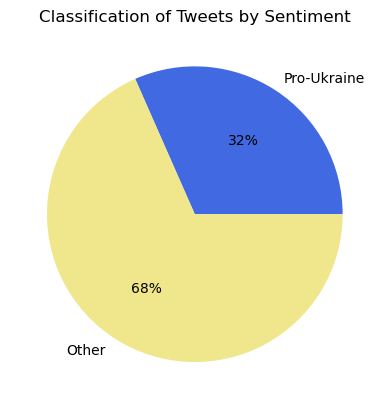

<Figure size 640x480 with 0 Axes>

In [56]:
total_pos = len(data.loc[data['sentiment']=='positive'])
total_neg = len(data.loc[data['sentiment']=='negative'])
total_tweets = len(data)
pie_data = [total_pos/total_tweets, total_neg/total_tweets]
keys = ['Pro-Ukraine', 'Other']
mycolors = ['royalblue','khaki']
plt.pie(pie_data, labels=keys, colors=mycolors, autopct='%.0f%%')
plt.title('Classification of Tweets by Sentiment')
plt.show()
plt.savefig('images/pie_tweets');

In [57]:
data['Searh'].unique()

array(['StandWithUkraine', 'Russia invade', 'Russian border Ukraine',
       'Russian troops', 'Ukraine border', 'Ukraine NATO',
       'Ukraine troops', 'Ukraine war'], dtype=object)

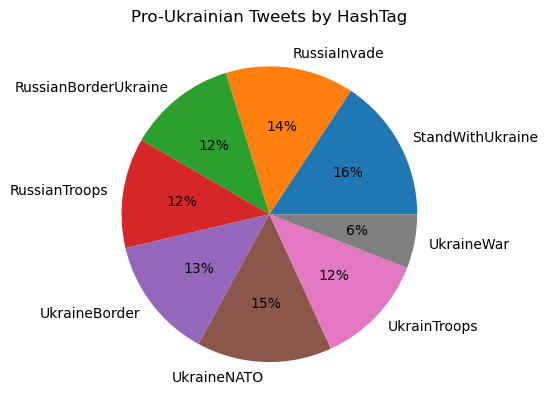

In [58]:
pos_sent = data[data['sentiment']=='positive']
total_sent = len(pos_sent)
swu_pos = len(pos_sent.loc[pos_sent['Searh']=='StandWithUkraine'])
ri_pos = len(pos_sent.loc[pos_sent['Searh']=='Russia invade'])
rbu_pos = len(pos_sent.loc[pos_sent['Searh']=='Russian border Ukraine'])
rt_pos = len(pos_sent.loc[pos_sent['Searh']=='Russian troops'])
ub_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine border'])
un_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine NATO'])
ut_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine troops'])
uw_pos = len(pos_sent.loc[pos_sent['Searh']=='Ukraine war'])
pie_data2 = [swu_pos/total_sent, ri_pos/total_sent, rbu_pos/total_sent, rt_pos/total_sent, ub_pos/total_sent,
            un_pos/total_sent, ut_pos/total_sent, uw_pos/total_sent]

keys = ['StandWithUkraine', 'RussiaInvade', 'RussianBorderUkraine', 'RussianTroops', 'UkraineBorder','UkraineNATO',
       'UkrainTroops','UkraineWar']
plt.pie(pie_data2, labels=keys, autopct='%.0f%%')
plt.title('Pro-Ukrainian Tweets by HashTag')
plt.show()

##### Evaluate sentiment analysis
Randomly select 100 tweets, manually classify and compare to results.

In [59]:
eval = data.sample(100)
eval.to_csv('eval.csv')

In [60]:
eval = pd.read_csv('eval.csv')

In [62]:
# eval['eval'].value_counts()

In [ ]:
eval['match'] = np.where((eval['eval']==eval['sentiment']),1, 0)
eval['match'].value_counts()

### Explore other features

In [63]:
# Convert date to datetime
date = data[['date','sentiment']]
date['date'] = pd.to_datetime(date['date'], format ='%Y-%m-%d')

C:\Users\Chelly Kearney\AppData\Local\Temp\ipykernel_792\235230994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date['date'] = pd.to_datetime(date['date'], format ='%Y-%m-%d')


In [64]:
date.info()
date.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 78698 to 203655
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       56000 non-null  datetime64[ns]
 1   sentiment  56000 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.3+ MB


,date,sentiment
78698,2022-02-26,positive
20118,2022-03-03,negative
41746,2022-03-01,positive
116235,2022-02-21,negative
73360,2022-02-26,negative


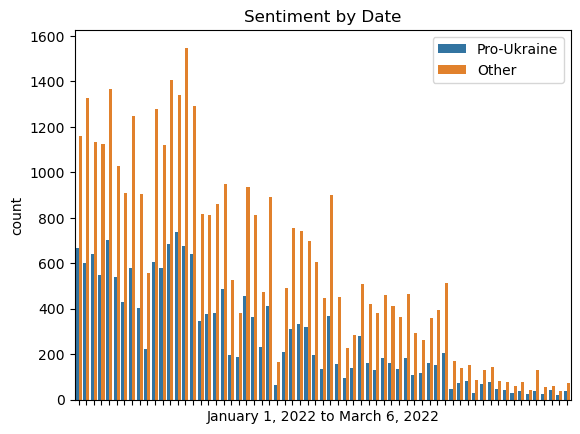

In [65]:
# date

sns.countplot(x = 'date', data=date, hue='sentiment')
plt.title('Sentiment by Date')
plt.xticks(visible=False)
plt.xlabel('January 1, 2022 to March 6, 2022')
plt.legend(['Pro-Ukraine','Other'])
plt.show();

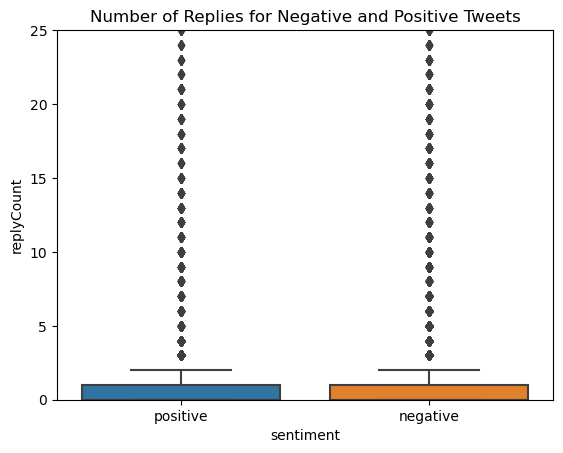

In [66]:
# reply count
sns.boxplot(x='sentiment', y='replyCount', data=data)
plt.ylim(0,25)
plt.title('Number of Replies for Negative and Positive Tweets');

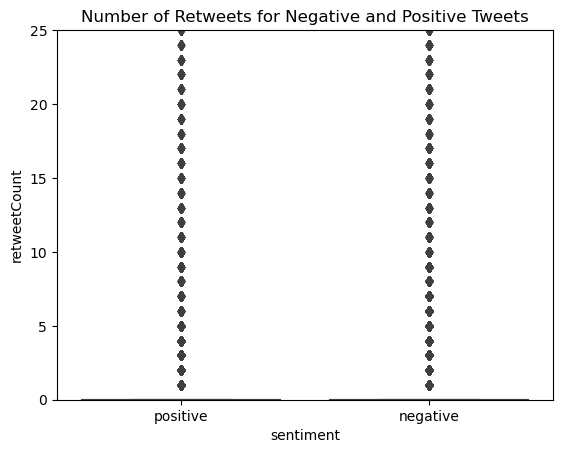

In [67]:
# retweet count
sns.boxplot(x='sentiment', y='retweetCount', data=data)
plt.ylim(0,25)
plt.title('Number of Retweets for Negative and Positive Tweets');

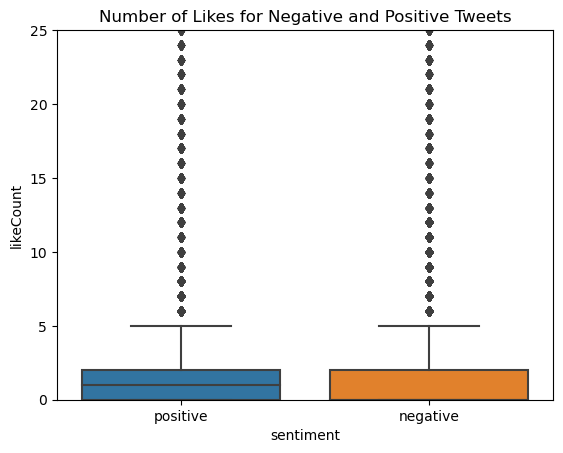

In [68]:
# like count
sns.boxplot(x='sentiment', y='likeCount', data=data)
plt.ylim(0,25)
plt.title('Number of Likes for Negative and Positive Tweets');

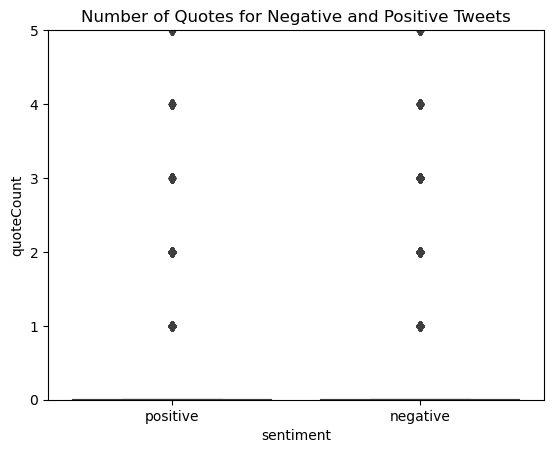

In [69]:
# quote count
sns.boxplot(x='sentiment', y='quoteCount', data=data)
plt.ylim(0,5)
plt.title('Number of Quotes for Negative and Positive Tweets');

In [70]:
# SourceLabel
data['sourceLabel'].value_counts()

Twitter Web App          19853
Twitter for iPhone       14849
Twitter for Android      13031
Twitter for iPad          1950
WordPress.com             1078
                         ...  
Nintendo Switch Share        1
Flashcrunch                  1
STCK.PR0                     1
Postfity.com                 1
Rojname News                 1
Name: sourceLabel, Length: 493, dtype: int64

In [71]:
# elminate tweets with only 1 unique value
list = ['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android', 'Twitter for iPad', 'TweetDeck']
data_pp = data[data['sourceLabel'].isin(list)]
data_pp['sourceLabel'].value_counts()

Twitter Web App        19853
Twitter for iPhone     14849
Twitter for Android    13031
Twitter for iPad        1950
TweetDeck                927
Name: sourceLabel, dtype: int64

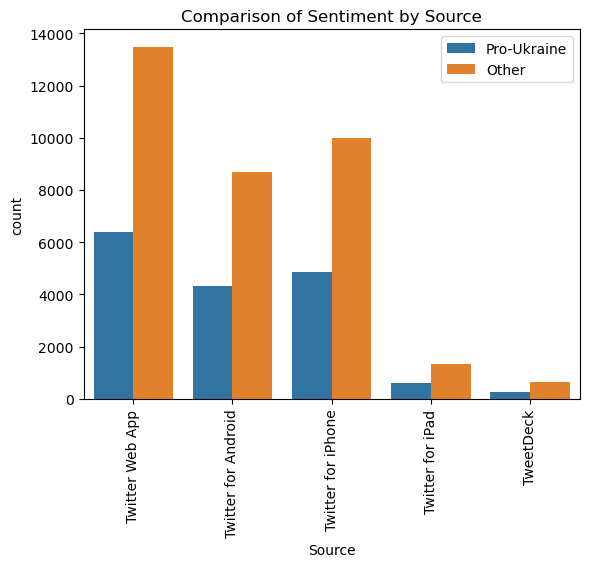

In [72]:
sns.countplot(x='sourceLabel', data=data_pp, hue = 'sentiment')
plt.xticks(rotation=90)
plt.xlabel('Source')
plt.title('Comparison of Sentiment by Source')
plt.legend(['Pro-Ukraine', 'Other'])
plt.savefig('images\source.png',bbox_inches='tight');

## Modeling

### Build training and test sets
* Eliminate hashtag - still needs preprocessing
* Elminate quoteCount - zero for both sentiments, useless

In [73]:
X = data_pp[['date','replyCount','retweetCount', 'likeCount', 'sourceLabel', 'Searh']]
y = data_pp['sentiment']

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y)

### Build a Baseline Model

In [75]:
y_test.value_counts(normalize=True)

negative    0.675571
positive    0.324429
Name: sentiment, dtype: float64

### Make a Column Transformer

In [76]:
# Convert oject columns to a numeric value
# Scale the numeric column
selector = make_column_selector(dtype_include=object)    # Select the object categories
transformer = make_column_transformer((OneHotEncoder(),selector), remainder=StandardScaler())

### Classification Model Using Logistic Regression

In [77]:
lr_pipe = Pipeline([
    ('transform', transformer),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)

In [78]:
lr_train_acc = lr_pipe.score(X_train,y_train)
lr_test_acc = lr_pipe.score(X_test,y_test)
print(lr_train_acc,lr_test_acc)

0.6758173722896962 0.6756500434679522


In [79]:
# Grid search to optimize LR
lr_params = {'extractor__max_features':[1,15,20,25,30,None]}
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42))
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
])
lr_grid = GridSearchCV(lr_pipe,param_grid=lr_params).fit(X_train,y_train)
lr_grid.best_params_

{'extractor__max_features': 20}

In [80]:
# Optimum number of features = 20, run model with 20 features
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42), max_features=20)
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)
lr_train_acc = lr_pipe.score(X_train,y_train)
lr_test_acc = lr_pipe.score(X_test,y_test)
print(lr_train_acc,lr_test_acc)

0.6756066074768817 0.6755710108274717


In [81]:
feature_names = lr_pipe.named_steps['transform'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lr_pipe.named_steps['extractor'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lr_pipe.named_steps['lr'].coef_[0]})
#coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df[0:20]

,feature,coefs
1,date_2022-01-04,0.429925
3,date_2022-01-09,0.331992
4,date_2022-01-12,0.280953
0,date_2022-01-02,0.278580
8,date_2022-01-28,0.267496
9,date_2022-01-30,0.205849
15,date_2022-02-15,0.201284
13,date_2022-02-09,0.193377
7,date_2022-01-22,-0.157588
11,date_2022-02-03,-0.211039


### Classification Model using K-Nearest Neighbors

In [137]:
knn_params = {'knn__n_neighbors':np.array(range(1,10,5))}

knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
])

import warnings
warnings.filterwarnings('ignore')
knn_grid = GridSearchCV(knn_pipe,param_grid = knn_params).fit(X_train,y_train)
knn_grid.best_params_

{'knn__n_neighbors': 6}

In [141]:
# Run the model with optimum k value
knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier(n_neighbors=6))
]).fit(X_train,y_train)

In [142]:
knn_train_preds = knn_pipe.predict(X_train)
knn_train_acc = accuracy_score(y_train,knn_train_preds)
knn_test_preds = knn_pipe.predict(X_test)
knn_test_acc = accuracy_score(y_test,knn_test_preds)
print(knn_train_acc,knn_test_acc)

0.7178715928449745 0.6676515212009901


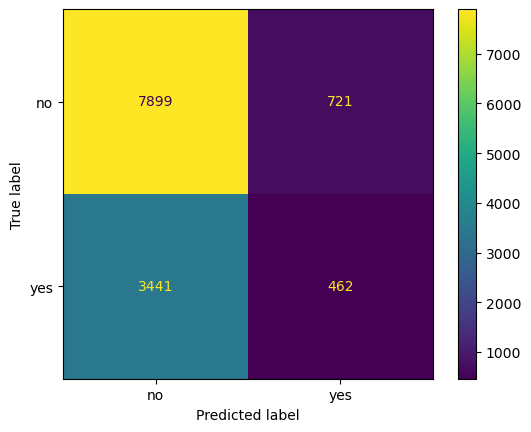

In [143]:
knn_confusion_mat  = confusion_matrix(y_test, knn_test_preds, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

### Classification Model using Decision Trees

In [82]:
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier())
])
dt_params = {'dt__max_depth': ['None', 3,8,12]}
dt_grid = GridSearchCV(dt_pipe,param_grid=dt_params).fit(X_train,y_train)
dt_grid.best_params_

C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 305, in fit
    if max_dep

{'dt__max_depth': 3}

In [83]:
# Run the model using optimum max_depth
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier(max_depth = 3))
]).fit(X_train,y_train)

In [84]:
dt_train_acc = dt_pipe.score(X_train,y_train)
dt_test_acc = dt_pipe.score(X_test,y_test)
print(dt_train_acc,dt_test_acc)

0.6756066074768817 0.6755710108274717


[Text(0.5, 0.875, 'onehotencoder__Searh_Ukraine war <= 0.5\ngini = 0.438\nsamples = 37957\nvalue = [25644, 12313]'),
 Text(0.25, 0.625, 'onehotencoder__Searh_StandWithUkraine <= 0.5\ngini = 0.455\nsamples = 33203\nvalue = [21602, 11601]'),
 Text(0.125, 0.375, 'onehotencoder__Searh_Ukraine NATO <= 0.5\ngini = 0.45\nsamples = 28233\nvalue = [18601, 9632]'),
 Text(0.0625, 0.125, 'gini = 0.444\nsamples = 23372\nvalue = [15590, 7782]'),
 Text(0.1875, 0.125, 'gini = 0.471\nsamples = 4861\nvalue = [3011, 1850]'),
 Text(0.375, 0.375, 'remainder__likeCount <= -0.015\ngini = 0.478\nsamples = 4970\nvalue = [3001, 1969]'),
 Text(0.3125, 0.125, 'gini = 0.475\nsamples = 4422\nvalue = [2710, 1712]'),
 Text(0.4375, 0.125, 'gini = 0.498\nsamples = 548\nvalue = [291, 257]'),
 Text(0.75, 0.625, 'remainder__retweetCount <= -0.048\ngini = 0.255\nsamples = 4754\nvalue = [4042, 712]'),
 Text(0.625, 0.375, 'onehotencoder__date_2022-02-22 <= 0.5\ngini = 0.266\nsamples = 3798\nvalue = [3199, 599]'),
 Text(0.562

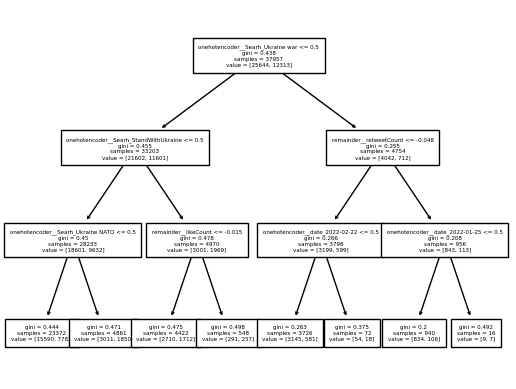

In [106]:
# Extract Rules
plot_tree(dt_pipe.named_steps['dt'], feature_names = dt_pipe.named_steps['transform'].get_feature_names_out(), fontsize=4)

## Evaluation

##### Build a Table to Compare Model Results

In [207]:
Model=['Logistic Regression','K-Nearest Neighbors','Decision Tree'] #,'Support Vector Machine']
Train = [lr_train_acc,knn_train_acc,dt_train_acc] #,svc_train_acc]
Test = [lr_test_acc,knn_test_acc,dt_test_acc] #,svc_test_acc]
#Prec = [lr_test_pre,knn_test_pre,dt_test_pre,svc_test_pre]
#Rec = [lr_test_rec,knn_test_rec,dt_test_rec,svc_test_rec]
Results = pd.DataFrame({'Model':Model,'Train Accuracy':Train,'Test Accuracy':Test}) #, 'Test Precision':Prec, 'Test Recall':Rec})
Results.set_index('Model')

,Train Accuracy,Test Accuracy
Model,,
Logistic Regression,0.688325,0.688094
K-Nearest Neighbors,0.717872,0.667652
Decision Tree,0.688299,0.688333


## Deployment

These are preliminary results. If we can build a successful model, we could scrape tweets and run through our model to track sentiment for a given time period.